# Meta Analysis

## Data Visualization

In [1]:
from collections import defaultdict
import seaborn as sns
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from wordcloud import WordCloud
from deep_utils import DirUtils

In [2]:
valid_mesh_df = pd.read_csv("mesh_df.csv")
descriptive_names = DirUtils.read_txt("descriptive_names.txt")
valid_mesh_df.head()

,PMID,Keywords,MeSH,MeSH_sub1,MeSH_sub2,year,month
0,38056602,*Cytidine/aa [Analogs & Derivatives],Cytidine,aa,Analogs & Derivatives,2024.0,Jan
1,38925480,*Aging/de [Drug Effects],Aging,de,Drug Effects,2024.0,Aug
2,38925480,*Environmental Exposure/ae [Adverse Effects],Environmental Exposure,ae,Adverse Effects,2024.0,Aug
3,38925480,*Pesticides/to [Toxicity],Pesticides,to,Toxicity,2024.0,Aug
4,38281844,*Dexamethasone/ad [Administration & Dosage],Dexamethasone,ad,Administration & Dosage,2024.0,May


# Cumulative Histogram

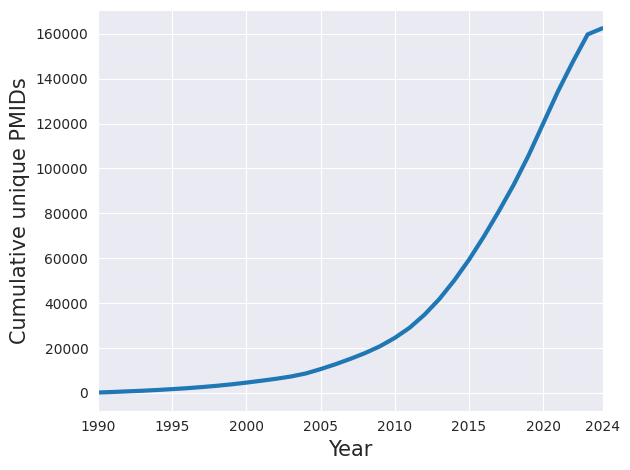

In [3]:
data = defaultdict(set)
for pmid, year in valid_mesh_df[['PMID', "year"]].values:
    data[int(year)].add(pmid)
year, unique_pmid_count = zip(*[(i,len(j)) for i,j in sorted(data.items())])
plt.plot(year, np.cumsum(unique_pmid_count), linewidth=3)
plt.xlim(1990, 2024)
plt.xticks(list(range(1990, 2024 +1, 5)) + [2024]);
plt.xlabel("Year", fontsize=15)
plt.ylabel("Cumulative unique PMIDs", fontsize=15)
plt.tight_layout()
plt.savefig("images/cumulative_histogram.jpg", dpi=300)

# Coefficient of Variation Bubble Plot

In [4]:
def get_cv(row):
    mean = np.mean(row)

    std_dev = np.std(row, ddof=1)  # ddof=1 for sample standard deviation
    # Calculate coefficient of variation
    cv = (std_dev / mean) * 100
    return cv, std_dev, mean


cv_data = defaultdict(lambda: defaultdict(set))
for pmid, mesh, sub_heading in valid_mesh_df[['PMID', 'MeSH', 'MeSH_sub2']].values:
    cv_data[sub_heading][mesh].add(pmid)
cv_data = {k: {item_k: len(item_v) for item_k, item_v in v.items()} for k, v in cv_data.items()}


# number of unique pmids for each sub heading
bubble_weight = defaultdict(set)
for pmid, mesh in valid_mesh_df[['PMID', 'MeSH_sub2']].values:
    bubble_weight[mesh].add(pmid)
bubble_weight = {k: len(v) for k, v in bubble_weight.items()}



cvf = {name: [*get_cv(list(row.values())), bubble_weight[name]] for name, row in cv_data.items()}
max_cv = max([get_cv(list(row.values()))[0] for  row in cv_data.values()])
cvf = {k: [v[0]/max_cv * 100, *v[1:]] for k,v in cvf.items()}
print("Max CV:", max_cv)

cvf_df = pd.DataFrame(cvf.values(), columns=['cv', 'std', 'mean', "weight"], index=cvf.keys())
cvf_df = cvf_df.reset_index()
cvf_df.head()

Max CV: 410.1876291553557


,index,cv,std,mean,weight
0,Analogs & Derivatives,52.921065,17.950113,8.269058,1748
1,Drug Effects,77.762464,19.622069,6.151659,4361
2,Adverse Effects,69.914286,30.405277,10.602309,16948
3,Toxicity,65.750178,10.787964,4.000000,659
4,Administration & Dosage,63.838272,24.426158,9.328063,8710


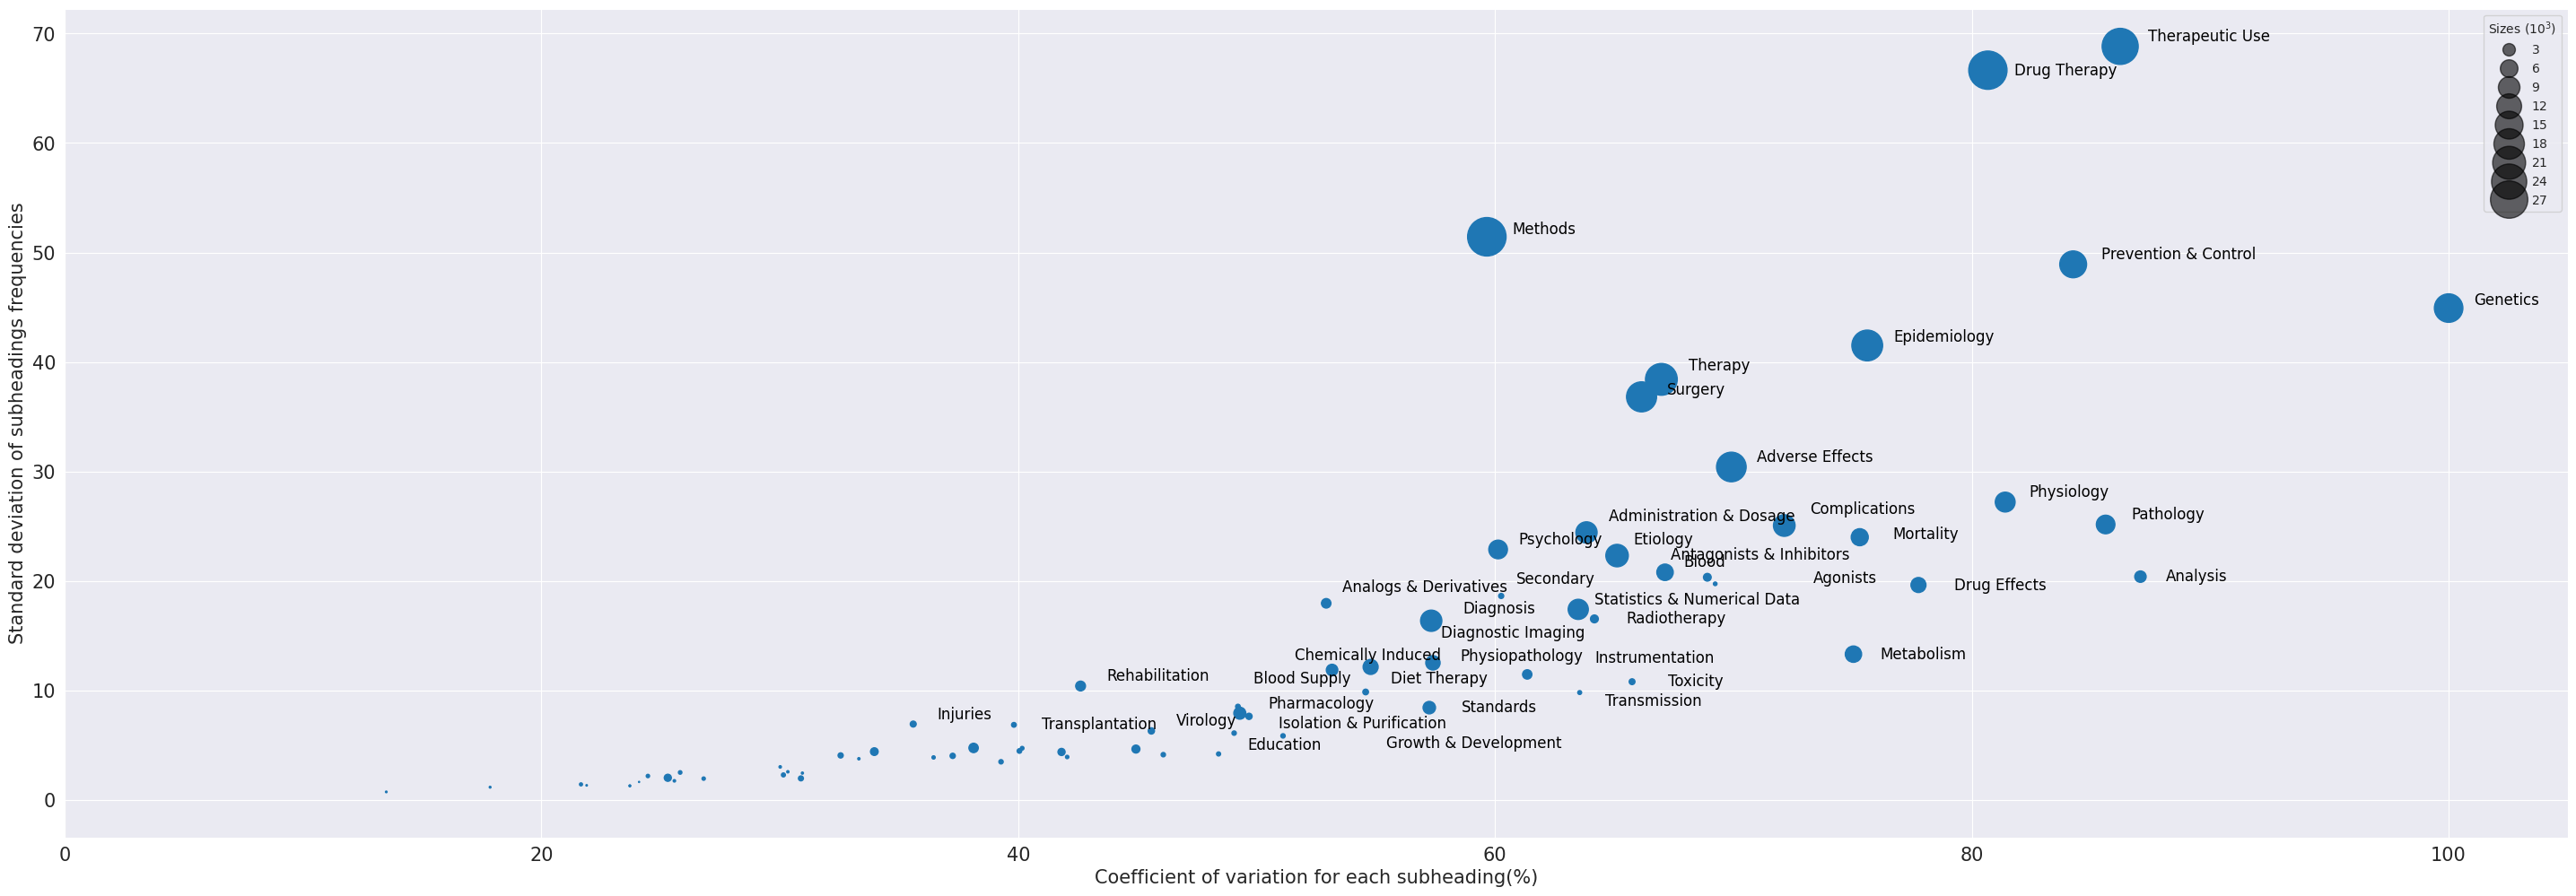

In [5]:
x = cvf_df['cv'].values
y = cvf_df['std'].values
names = cvf_df['index'].values
scale = 30
size = cvf_df['weight'].values / scale

fig, ax = plt.subplots(figsize=(36, 12))
scatter = ax.scatter(x, y,  s=size)
ax.set_xlabel("Coefficient of variation for each subheading(%)", fontsize=15)
ax.set_ylabel("Standard deviation of subheadings frequencies", fontsize=15)
ax.tick_params(axis="both", labelsize=15)
# fig = plt.scatter(x=x, y=y, s=size, color="blue", alpha=0.6, )
texts = []
for index, (x_, y_, name) in enumerate(zip(x, y, names)):
    if x_ > 2000 or y_ > 5:
        txt = plt.text(
            x_  + 1,
            y_,
            name,
            fontsize=12,
            # fontdict=font,
            ha='left',
            color="black"
            # weight='bold'
        )
        texts.append(txt)
ax.set_xlim(0, 105)
adjust_text(texts)
def fix_label(input_str, scale, rescale=1000):
    left_index = input_str.index("{") + 1
    right_index = input_str.index("}")
    new_val = round(int(input_str[left_index: right_index]) * scale /rescale)
    return input_str[:left_index] + str(new_val) + input_str[right_index:]

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, [fix_label(l, scale) for l in labels], loc="upper right", title=r"Sizes ($10^3$)")
plt.savefig("images/bubble_plot.jpg", dpi=300)

# Scatter Plot

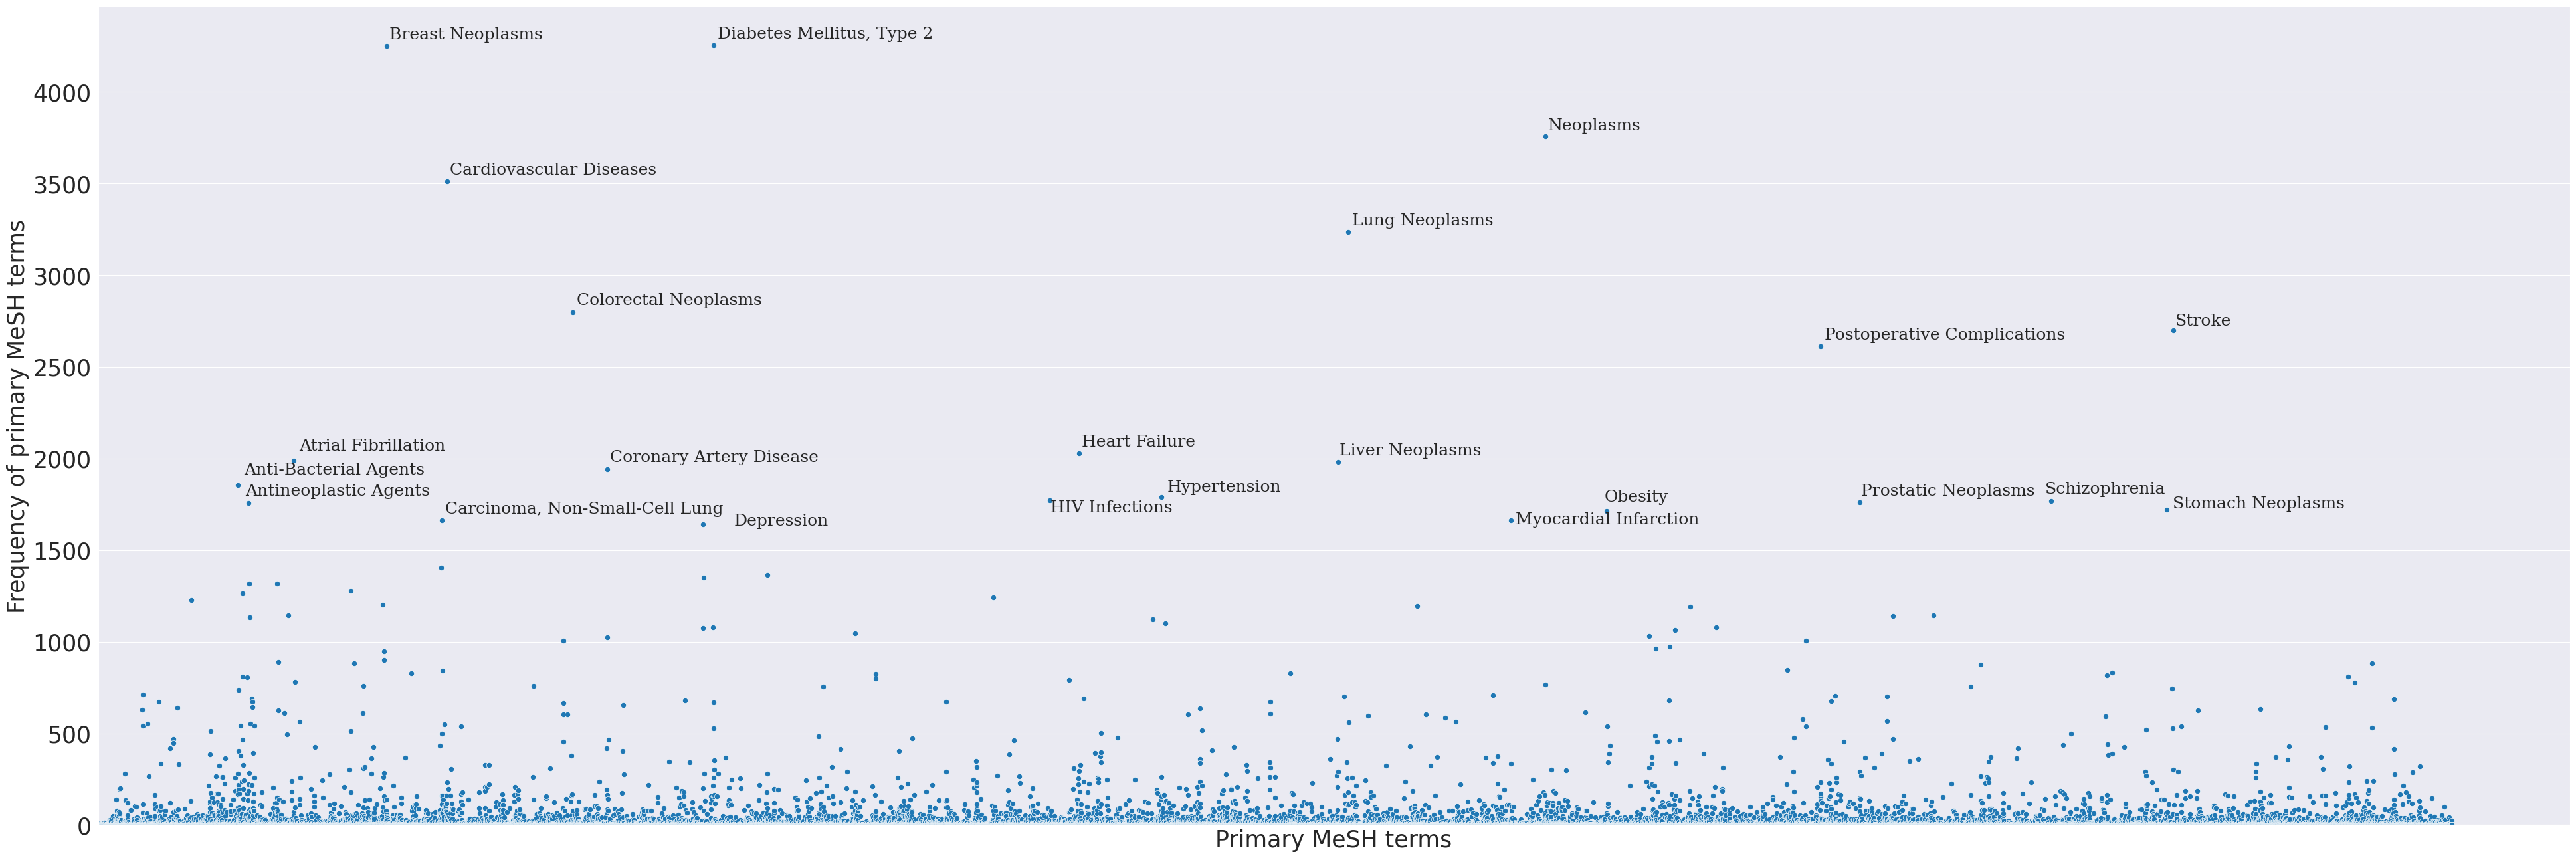

In [6]:
mesh_names_dict = dict(Counter(valid_mesh_df['MeSH']))
data = pd.DataFrame([[sample, mesh_names_dict.get(sample, 0)] for sample in descriptive_names],
                    columns=["mesh_name", "mesh_count"])
fig, ax = plt.subplots(1, 1, figsize=(48, 16))
ax.set_xticks([])

ax.set_xlabel("Primary MeSH terms", fontsize=25)
ax.set_ylabel("Frequency of primary MeSH terms", fontsize=25)
sns.scatterplot(x=list(range(len(descriptive_names))), y=data['mesh_count'].values, ax=ax)
ax.tick_params(axis="both", labelsize=25)
font = {'family': 'serif',
        # 'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }
ax.set_xlim(0)
ax.set_ylim(0)
texts = []
for index, (name, count) in enumerate(data.values):
    if count > 1500:
        subheading = valid_mesh_df[valid_mesh_df["MeSH"] == name]['MeSH_sub2'].unique()
        # if len(subheading) == 1:
        #     name = name + f"({subheading[0]})"
        # else:
        #     print(len(subheading))
        txt = plt.text(
            index,
            count + 10,
            name,
            fontdict=font,
            ha='left',
            # weight='bold'
        )
        texts.append(txt)
adjust_text(texts)
plt.savefig("images/scatter_plot.jpg", dpi=300)

# Word Cloud

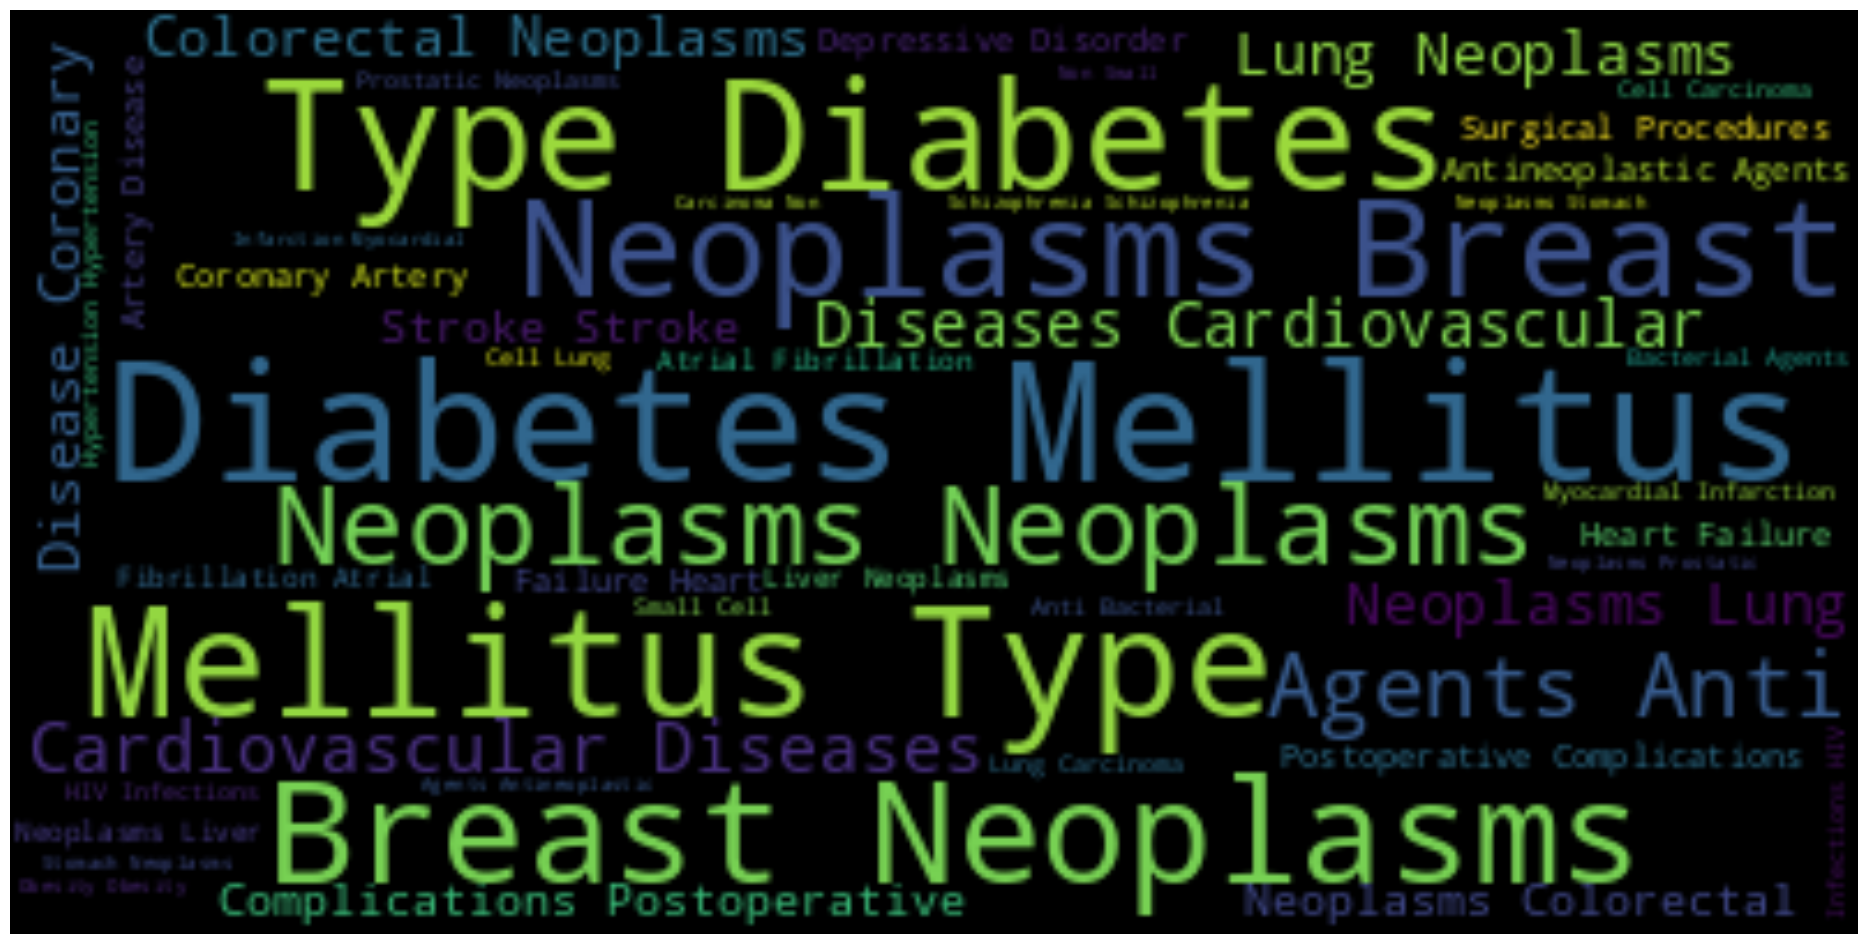

In [7]:
mesh_names_dict = dict(Counter(valid_mesh_df['MeSH']))
text = " ".join([(k + " ") * v for k, v in mesh_names_dict.items()])
wordcloud = WordCloud().generate(text, )

plt.figure(figsize=(32, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("images/most_word_cloud.jpg", dpi=500)


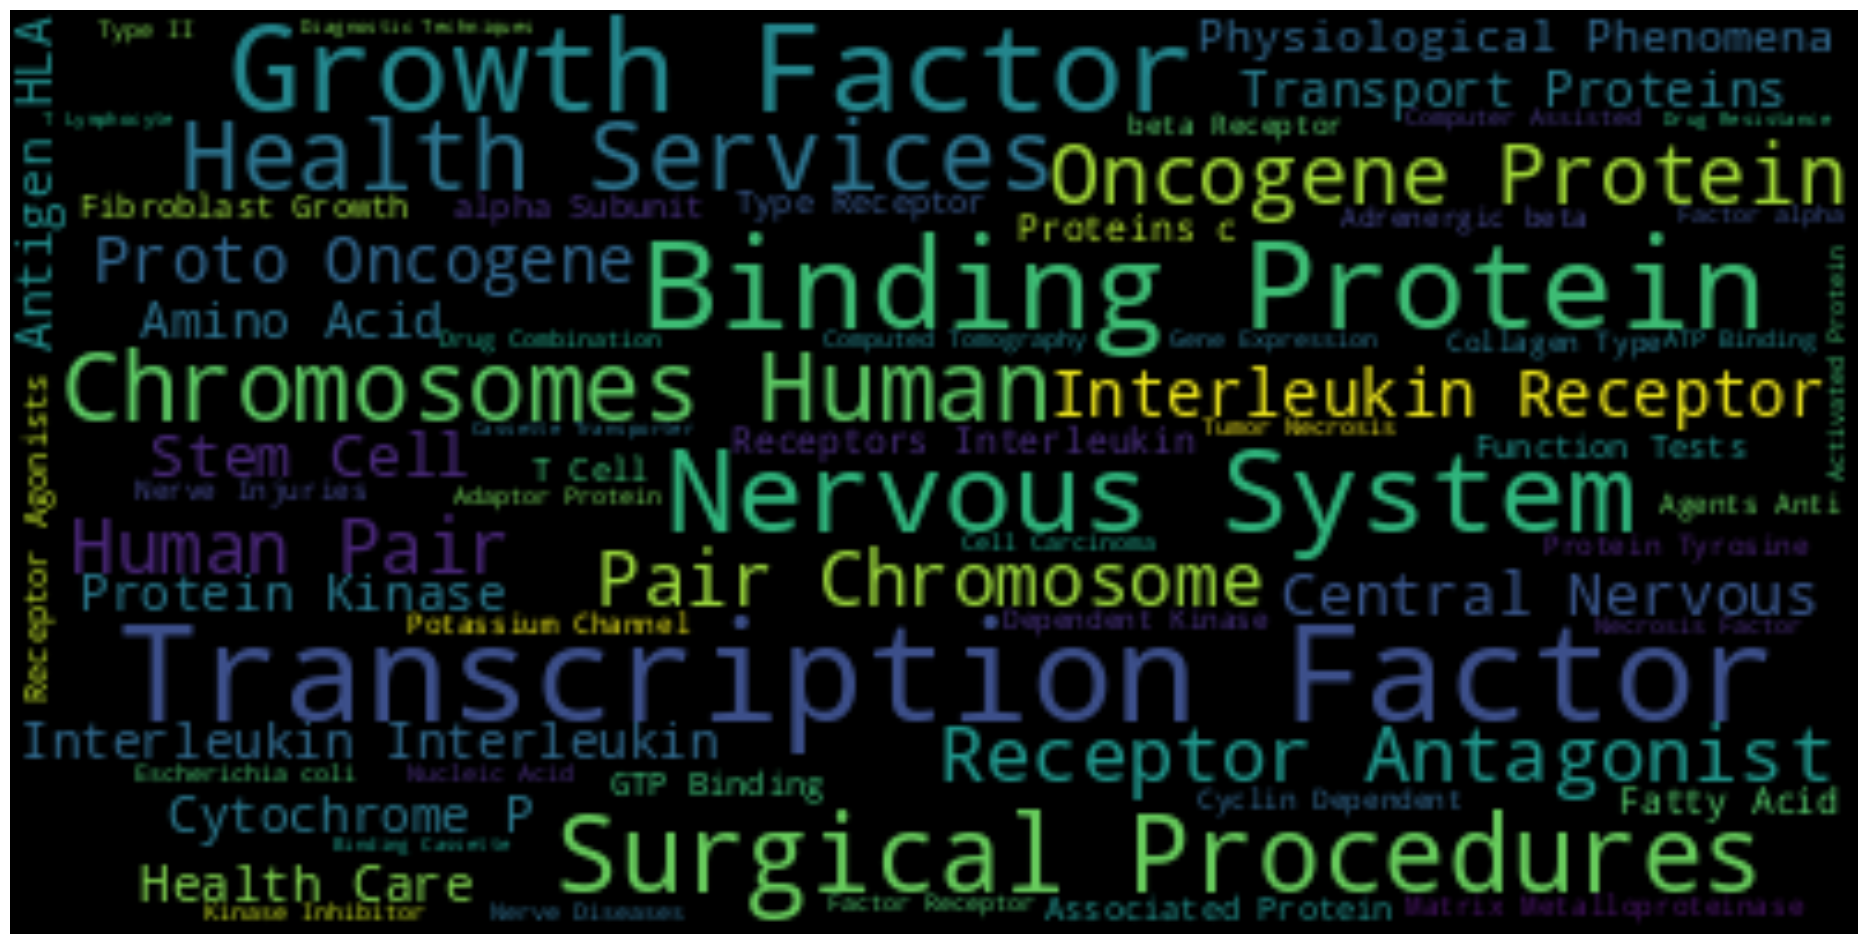

In [8]:
max_occurance = max(mesh_names_dict.items(), key=lambda x: x[1])[1]
text = " ".join([(k + " ") * (abs(v - max_occurance + 1)) for k, v in mesh_names_dict.items()])

# Generate a word cloud image
wordcloud = WordCloud().generate(text, )

plt.figure(figsize=(32, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("images/least_word_cloud.jpg", dpi=500)